In [1]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
#import required libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import joblib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from google.colab import drive
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #set device to GPU for fast processing if available


In [4]:
print(device)

cuda


In [5]:
#mount the drive to load test data and two best models
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
nltk.download('stopwords') #download stopwords
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Load Test Data from Drive**

In [8]:
test_df = pd.read_csv('/content/drive/My Drive/NLP_Coursework/test.csv')# load test data from the drive
test_df.head() # display first 5 observations

,Unnamed: 0,text,label
0,23703,ý thýnk uzak ýs the one of the best films of a...,1
1,1717,This movie started out as a quite decent-looki...,0
2,2696,"As was mentioned before in other comments, the...",0
3,1848,Ghoulies IV starts in a museum storage facilit...,0
4,10623,I watched this as part of a vampire movie mara...,0


**Test Best Baseline Model**

In [9]:
#Load baseline model from the drive
baseline_model = joblib.load('/content/drive/My Drive/NLP_Coursework/Baseline_best_model')

In [10]:
#preprocessing data

happy_emojis = [':-D', ':)', ':P', ';)', ';-)']
sad_emojis = [':(', ';(', ':—',':-(']

#define expanding contraction
dict = {
    'don\'t': 'do not',
    'didn\'t': 'did not',
    'thx': 'thanks',
    'thnx': 'thanks',
    'shouldn\'t': 'should not',
    'wouldn\'t': 'would not',
    'couldn\'t': 'could not',
    'haven\'t': 'have not',
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "isn't" : "is not"

}

#define pre-process function
def preprocess(text):
    text = text.lower() #lowercase the rext
    text = re.sub('<br />', '', text) #remove hyperlink
    text = re.sub(r'http\S+', '', text) #remove webaddress
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # Replace emotion patterns
    for emoji in happy_emojis:
        text = text.replace(emoji, 'happy')
    for emoji in sad_emojis:
        text = text.replace(emoji, 'sad')


    puntuation_pattern = re.compile(r'\b(' + '|'.join(dict.keys()) + r')\b')
    text = puntuation_pattern.sub(lambda x: dict[x.group(0)], text) #replace short forms with full forms

    text = text.replace('?', ' questionmark') #define ? and ! to a word which could define emotions of positive and
    text = text.replace('!', ' exclamatorymark')

    text = re.sub('[^a-zA-Z]', ' ', text) #remove non alphabatical character

    tokens = re.findall(r'\b\w+\b', text) # text to tokens, split on space


    # lemitization and remove stop words
    lemmatize = WordNetLemmatizer()
    stopWords = set(stopwords.words('english'))
    stopWords = set(stopWords)
    stopWords.discard('not') # not including not in stop word
    stopWords.discard('but') #not including but in stop word

    text_lemma = [lemmatize.lemmatize(word) for word in tokens if word not in stopWords]


    text = ' '.join(text_lemma) #convert to original text by joining with space

    return text

In [11]:
x_test_baseline = [preprocess(text) for text in test_df['text']] #pre-process test data reviews

In [12]:
y_pred_baseline = baseline_model.predict(x_test_baseline)#predict labels (0-negative and 1- positive)

In [13]:
#performance metrics
print('Baseline Model Performance:')
print('Accuracy: ', accuracy_score(test_df['label'], y_pred_baseline))
print('Precision: ', precision_score(test_df['label'], y_pred_baseline))
print('F1_score: ', f1_score(test_df['label'], y_pred_baseline))

Baseline Model Performance:
Accuracy:  0.9016
Precision:  0.9095276220976781
F1_score:  0.9023034154090549


Text(50.722222222222214, 0.5, 'True Labels')

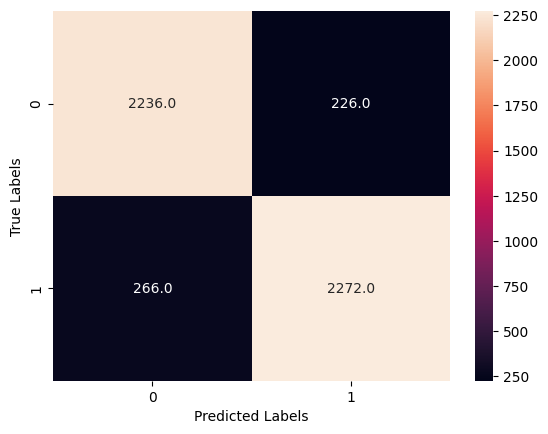

In [14]:
#confusion matrix as performance metrics
sns.heatmap(confusion_matrix(test_df['label'],y_pred_baseline), annot=True, fmt= '.1f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

**Test Best improved model: Trained on pre-trained Bert Model**

In [15]:
#Define pre-processing function required for model
def tranformerPreprocess(text):
  text = text.lower() # Convert text to lowercase
  text = re.sub('<br />', ' ', text)  #remove html tags
  text = re.sub(r'http\S+', '', text) # remove urls

  return text

In [16]:
x_test = [tranformerPreprocess(text) for text in test_df['text']] #pre-processing required for test reviews
y_test = test_df['label']

In [20]:
#Load Bert Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
#load best model from the drive in specified path
best_model_dir = "/content/drive/MyDrive/NLP_Coursework/bert_model_final2"

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)

In [21]:
model.to(device)
##using for loop to predict labels and store in a list: tokenizing and predicting labels
y_pred_test_list = []
for i in range(len(x_test)):
    tokenize_text = tokenizer(x_test[i], truncation=True, padding=True, max_length=512, return_tensors="pt")

    # assign tensors to GPU
    input_ids = tokenize_text['input_ids'].to(device)
    attention_mask = tokenize_text['attention_mask'].to(device)

    #make predictions
    y_pred_test = model(input_ids=input_ids, attention_mask=attention_mask)
    y_pred_test = y_pred_test.logits
    y_prob = torch.softmax(y_pred_test, dim=1)
    y_pred = torch.argmax(y_prob, dim=1).item()
    y_pred_test_list.append(y_pred)

In [22]:
# Test performance of model by confusion matrix , Accuracy, F1 score and Precision

Text(50.722222222222214, 0.5, 'True Labels')

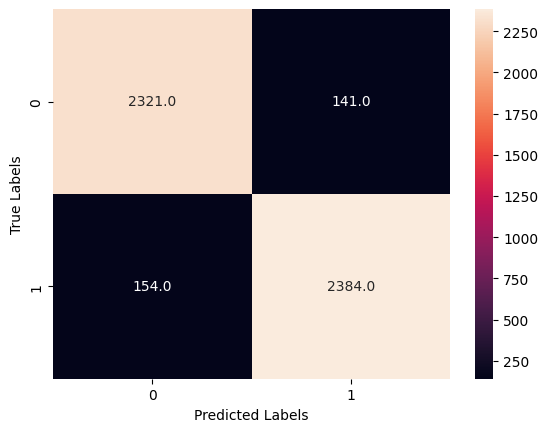

In [23]:
sns.heatmap(confusion_matrix(test_df['label'],y_pred_test_list), annot=True,fmt= '.1f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [24]:
print('Transformer Performance:')
print('Accuracy: ', accuracy_score(test_df['label'], y_pred_test_list))
print('Precision: ', precision_score(test_df['label'], y_pred_test_list))
print('F1_score: ', f1_score(test_df['label'], y_pred_test_list))

Transformer Performance:
Accuracy:  0.941
Precision:  0.9441584158415841
F1_score:  0.9417341497136085
